In [1]:
import os, sys
from tqdm import trange, tqdm

import math
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import plotly.graph_objects as go


source = "../source"
sys.path.append(source)

from data_analysis.visualization.publication import pub_show
from simulate import der, rep_sim

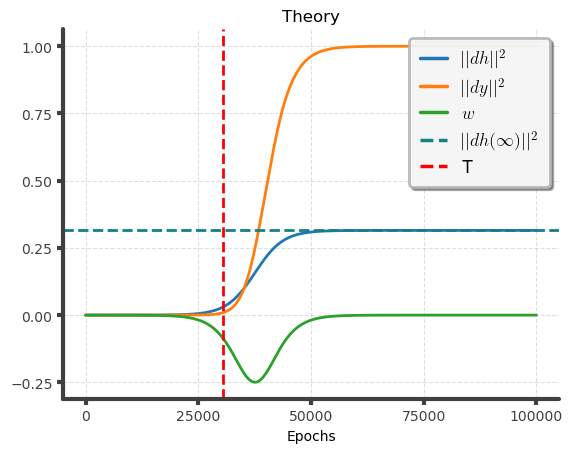

In [2]:
## Comparison
dx2 = 1
dy2 = 1
D0 = 1e-5
theta = -0.1  # between 1 and -1

eta_h = 0.0001
eta_y = eta_h * 10

h0 = 1 * D0 * dx2
y0 = 2 * D0**2 * dx2
w0 = y0 - theta * np.sqrt(y0 * dy2)

epochs = np.arange(100000)


t_max = len(epochs)


sol = scipy.integrate.solve_ivp(
    der, [0, t_max], [h0, y0, w0], args=[eta_h, eta_y, dx2, dy2], dense_output=True
)

t = np.linspace(0, t_max, len(epochs))
z = sol.sol(t)


A_low = np.sqrt((eta_h / eta_y) * dy2 * dx2)
A_high = (h0 / dx2 - (eta_h / eta_y) * y0 / h0) * dx2
h_inf = 0.5 * (A_high + np.sqrt(A_high**2 + 4 * A_low**2))


fig, ax = plt.subplots()
plt.plot(t, z[0], label="$||dh||^2$")
plt.plot(t, z[1], label="$||dy||^2$")
plt.plot(t, z[2], label="$w$")
ax.set_prop_cycle(None)
plt.axhline(h_inf, linestyle="--", label="$||dh(\infty)||^2$")
plt.axvline(
    1 / (np.sqrt(eta_h * eta_y) * np.sqrt(dx2 * dy2)) * np.log(0.5 * A_low / h0),
    linestyle="--",
    color="r",
    label="T",
)
ax.legend()
plt.xlabel("Epochs")
plt.title("Theory")
pub_show()

0.49950000000000006
0.49950000000000006
0.49950000000000006
0.4995000000000001
0.49950000000000006
0.49949999995085154
0.4994881055577375
0.49716581040276464
0.47534837020795667
0.4274615393560829


/tmp/ipykernel_500/174343931.py:7: RuntimeWarning: divide by zero encountered in divide
  (1 + A_low**2 / x**2)
/tmp/ipykernel_500/174343931.py:9: RuntimeWarning: divide by zero encountered in divide
  * np.exp(-0.5 * ((x - A_low**2 / x) / (np.sqrt(2) * G)) ** 2)
/tmp/ipykernel_500/174343931.py:7: RuntimeWarning: invalid value encountered in multiply
  (1 + A_low**2 / x**2)


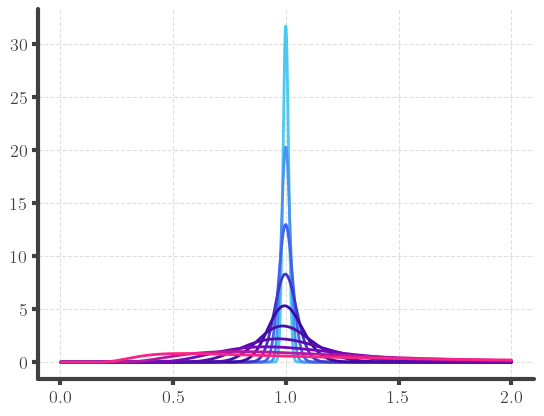

In [4]:
## Final distribution
x = np.linspace(0, 2, 1000)
A_low = 1
Gs = np.logspace(-1.75, 0, 10)
for G in Gs:
    f = (
        (1 + A_low**2 / x**2)
        / (2 * np.sqrt(np.pi) * G)
        * np.exp(-0.5 * ((x - A_low**2 / x) / (np.sqrt(2) * G)) ** 2)
    )
    plt.plot(x, f)
    print(np.sum(f[1:]) / 1000)

pub_show(colors="gradient 1")

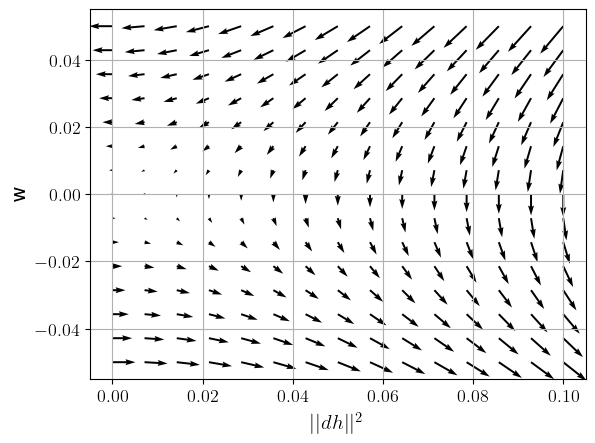

In [105]:
N = 15

D0 = 1e-1
dx2 = 1
dy2 = 1
eta_h = 1
eta_y = 1

h0 = 1 * D0 * dx2
y0 = 2 * D0**2 * dx2


h, w = np.meshgrid(np.linspace(0, 0.1, N), np.linspace(-0.05, 0.05, N))

dhdt = -eta_h * dx2 * w
dwdt = -0.5 * (
    -(eta_y**2) / eta_h * 1 / dx2 * h**3
    + eta_y * dy2 * h
    + 4 * eta_y * h * w
    + eta_h * dx2 * w**2 * h
    + (y0 / h0 - (eta_y / eta_h) * h0 / dx2) * (eta_h * dx2 * w - eta_y * h**2)
)

A_low = np.sqrt((eta_h / eta_y) * dy2 * dx2)
A_high = (h0 / dx2 - (eta_h / eta_y) * y0 / h0) * dx2
h_inf = 0.5 * (A_high + np.sqrt(A_high**2 + 4 * A_low**2))

plt.quiver(h, w, dhdt, dwdt)
# plt.scatter(h_inf, 0)

plt.grid()
plt.xlabel("$||dh||^2$")
plt.ylabel("w")
plt.show()

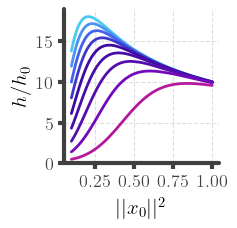

In [4]:
## Vary x0

N = 100
M = 10
dy2 = 1
D0 = 0.1
x0s = np.linspace(0.1, 1, N)

hs = np.zeros((N, N))
for i, x0 in enumerate(x0s):
    h0 = D0 * x0
    y0 = D0**2 * x0
    w0s = np.linspace(
        y0 - np.sqrt(y0 * dy2),
        y0 + np.sqrt(y0 * dy2),
        M,
    )
    for j, w0 in enumerate(w0s):
        hs[i, j] = rep_sim(h0, y0, w0, x0, dy2)

fig = plt.figure(figsize=(2, 2))
for j in range(M):
    plt.plot(x0s, np.array(hs[:, j]) / (D0 * np.array(x0s)))
plt.xlabel("$||x_0||^2$")
plt.ylabel("$h/h_0$")
plt.ylim(0)
pub_show(colors="gradient")

100it [00:01, 93.20it/s]


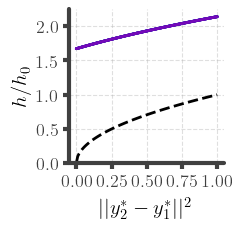

In [5]:
## Vary dy
N = 100
M = 10
x0 = 1
D0 = 2
randomness = 0.9
dys = np.linspace(0, 1, N)

h0 = D0 * x0
hs = np.zeros((N, N))
for i, dy2 in tqdm(enumerate(dys)):
    y0 = randomness**D0**2 * x0
    w0s = np.linspace(
        y0 - np.sqrt(y0 * dy2),
        y0 + np.sqrt(y0 * dy2),
        M,
    )
    for j, w0 in enumerate(w0s):
        hs[i, j] = rep_sim(h0, y0, w0, x0, dy2)

fig = plt.figure(figsize=(2, 2))
for j in range(M - 2):
    plt.plot(dys, hs[:, j])
plt.plot(dys, np.sqrt(dys * x0), linestyle="--", color="black")
plt.xlabel("$||y_2^*-y_1^*||^2$")
plt.ylabel("$h/h_0$")
plt.ylim(0)
# plt.legend(loc="center left", bbox_to_anchor=(1.04, 1), borderaxespad=0)
# plt.arrow(1.1, 40, 0, -10, head_width=0.08, head_length=2, color="black")
ax = plt.gca()
ax.annotate(
    "larger $w_0$",
    xy=(1.05, 22),
    xytext=(1.05, 42),
    arrowprops=dict(
        facecolor="black", shrink=0.05, width=0.5, headwidth=5, headlength=5
    ),
)
pub_show(colors="gradient 2")
# plt.show()

100it [00:03, 33.02it/s]


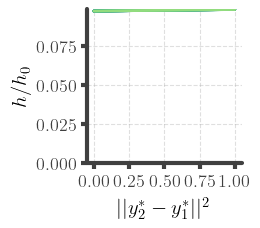

In [6]:
## Vary dy
N = 100
M = 10
x0 = 1
D0 = 100
randomness = 0.9
dys = np.linspace(0, 1, N)

h0 = D0 * x0
hs = np.zeros((N, N))
for i, dy2 in tqdm(enumerate(dys)):
    y0 = randomness * D0**2 * x0
    w0s = np.linspace(
        y0 - np.sqrt(dy2 * y0),
        y0 + np.sqrt(dy2 * y0),
        M,
    )
    for j, w0 in enumerate(w0s):
        hs[i, j] = rep_sim(h0, y0, w0, x0, dy2)

fig = plt.figure(figsize=(2, 2))
for j in range(M - 2):
    plt.plot(dys, hs[:, j] / h0)
plt.xlabel("$||y_2^*-y_1^*||^2$")
plt.ylabel("$h/h_0$")
plt.ylim(0)
# plt.legend(loc="center left", bbox_to_anchor=(1.04, 1), borderaxespad=0)
# plt.arrow(1.1, 40, 0, -10, head_width=0.08, head_length=2, color="black")
ax = plt.gca()
ax.annotate(
    "larger $w_0$",
    xy=(1.05, 0.7),
    xytext=(1.05, 1.4),
    arrowprops=dict(
        facecolor="black", shrink=0.05, width=0.5, headwidth=5, headlength=5
    ),
)
pub_show(colors="gradient 2")
# plt.show()

100%|██████████| 10/10 [00:01<00:00,  7.29it/s]


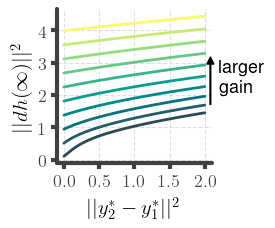

In [7]:
## Vary dy Different scales

N = 100
M = 10
x0 = 1
randomness = 0.6
D0s = np.linspace(0.2, 10, 10)
dys = np.linspace(0, 2, N)

fig = plt.figure(figsize=(2, 2))
for D0 in tqdm(D0s):
    h0 = D0 * x0
    hs = np.zeros(N)
    for i, dy2 in enumerate(dys):
        y0 = randomness * D0**2 * x0
        hs[i] = rep_sim(h0, y0, y0, x0, dy2)
    plt.plot(dys, hs)

plt.xlabel("$||y_2^*-y_1^*||^2$")
plt.ylabel("$||dh(\infty)||^2$")
# plt.ylim(0, 10)
ax = plt.gca()
ax.text(1.05 * ax.get_xlim()[1], 0.45 * ax.get_ylim()[1], "larger \n gain")
ax.annotate(
    "",
    xy=(0.99 * ax.get_xlim()[1], 0.7 * ax.get_ylim()[1]),
    xytext=(0.99 * ax.get_xlim()[1], 0.35 * ax.get_ylim()[1]),
    arrowprops=dict(
        facecolor="black", shrink=0.05, width=0.5, headwidth=5, headlength=5
    ),
)
pub_show(colors="gradient 1")

100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


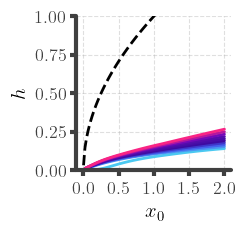

In [8]:
## Vary x0 Different scales

N = 100
M = 10
randomness = 0.9
D0s = np.linspace(0.01, 10, 10)
x0s = np.linspace(0.001, 2, N)
dy2 = 1

fig = plt.figure(figsize=(2, 2))
for D0 in tqdm(D0s):
    hs = np.zeros((N, N))
    for i, x0 in enumerate(x0s):
        h0 = D0 * x0
        y0 = randomness * D0**2 * x0
        w0s = np.linspace(
            y0 - np.sqrt(dy2 * y0),
            y0 + np.sqrt(dy2 * y0),
            M,
        )
        for j, w0 in enumerate(w0s):
            hs[i, j] = rep_sim(h0, y0, w0, x0, dy2)
    plt.plot(x0s, np.mean(hs, axis=1))
plt.plot(x0s, np.sqrt(dy2 * x0s), linestyle="--", color="black")

plt.xlabel("$x_0$")
plt.ylabel("$h$")
plt.ylim(0, 1)
pub_show(colors="gradient")

In [ ]:
## Vary x0,dy Different scales

N = 20
M = 10
D0 = 0.01
x0s = np.linspace(0.01, 0.1, N)
dys = np.linspace(0, 1, N)
dy2 = 1

fig = plt.figure(figsize=(4, 4))
hs = np.zeros((N, N))
for i, dy2 in enumerate(dys):
    for j, x0 in enumerate(x0s):
        h0 = D0 * x0
        y0 = np.max((D0**2 * x0, dy2))
        w0s = np.linspace(
            D0**2 * x0 - np.sqrt(dy2 * D0**2 * x0),
            D0**2 * x0 + np.sqrt(dy2 * D0**2 * x0),
            M,
        )
        for w0 in w0s:
            hs[i, j] += (1 / M) * rep_sim(h0, y0, w0, x0, dy2) / h0


plt.imshow(hs)
plt.xlabel("$x_0$")
plt.ylabel("$||y_2^*-y_1^*||^2$")

pub_show()

In [5]:
# Plot

x = dys
y = D0s
z = hs / h0
# z = scipy.ndimage.filters.gaussian_filter(z, 0.5, mode="constant")

fig = go.Figure(
    data=[
        go.Surface(
            x=x,
            y=y,
            z=z,
        ),
    ]
)

fig.update_layout(
    # title="Validation loss",
    autosize=False,
    width=600,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90),
)
fig.update_scenes(
    xaxis_title_text="y_0/h_0",
    yaxis_title_text="||y_2-y_1||^2",
    zaxis_title_text="h/h_0",
)

fig.show()

NameError: name 'dys' is not defined